In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from model import OrthogonalAutoEncoder
from training_utils import TrainingModel
from gradients import get_integrated_gradients

In [2]:
# AI4I data from https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset
# only keeping columns Type_L, Type_M, Type_H (these three are dummy variables), Air_temperature, Process_temperature, Rotational_speed, Torque, Tool_wear, y
df = pd.read_csv("/Users/dcac/Data/ai4i/ai4i2020_reduced.csv").iloc[:1000, :]
df = df[df["y"] == 0].drop(["y"], axis=1)  # clean training data to fit the model

In [3]:
# Scaling data
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df))
x = torch.Tensor(df.values)

In [4]:
# Initiating model
model = OrthogonalAutoEncoder(encoding_layers=[8, 5], activation_function=nn.ReLU(), dropout=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)  # number of parameters

OrthogonalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
)


119

In [5]:
# Training model (validation loss is lower because of dropout)
train = TrainingModel(penalty=0.1, learning_rate=0.001, batch_size=20, val_size=0.20, verbose=True)
train_loader, valid_loader = train.create_datasets(train_data=x)
trained_model, losses = train.train_model(model, patience=10, n_epochs=1000)

[   1/1000] train_loss: 12.388441 valid_loss: 11.268747
Validation loss decreased (inf --> 11.268747).  Saving model ...
[   2/1000] train_loss: 9.725262 valid_loss: 11.828803
EarlyStopping counter: 1 out of 10
[   3/1000] train_loss: 8.091206 valid_loss: 8.219173
Validation loss decreased (11.268747 --> 8.219173).  Saving model ...
[   4/1000] train_loss: 6.801481 valid_loss: 8.447319
EarlyStopping counter: 1 out of 10
[   5/1000] train_loss: 5.989758 valid_loss: 6.315442
Validation loss decreased (8.219173 --> 6.315442).  Saving model ...
[   6/1000] train_loss: 5.144346 valid_loss: 6.209568
Validation loss decreased (6.315442 --> 6.209568).  Saving model ...
[   7/1000] train_loss: 4.618308 valid_loss: 4.272415
Validation loss decreased (6.209568 --> 4.272415).  Saving model ...
[   8/1000] train_loss: 4.093916 valid_loss: 4.168397
Validation loss decreased (4.272415 --> 4.168397).  Saving model ...
[   9/1000] train_loss: 3.624077 valid_loss: 3.575077
Validation loss decreased (4.1

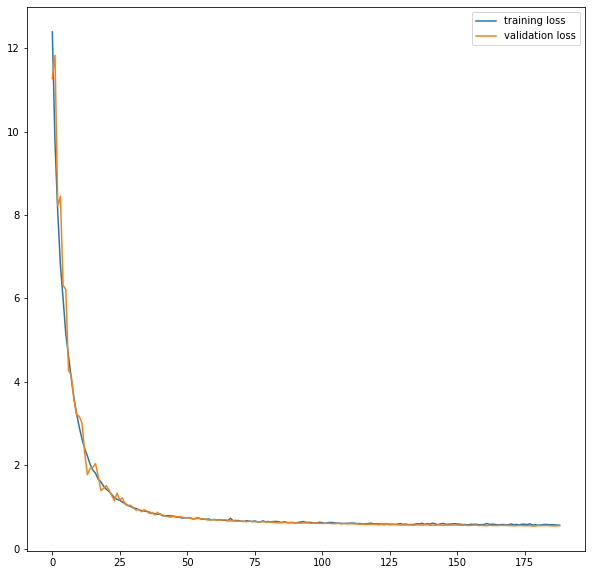

In [6]:
# Plot losses
plt.figure(figsize=(10, 10))
plt.plot(losses["train"], label="training loss")
plt.plot(losses["val"], label="validation loss")
plt.legend()
plt.show()

In [7]:
# Saving trained model
torch.save(trained_model, "orthogonal_autoencoder.pt")

In [8]:
base = x.mean(axis=0)
example = x[0]
get_integrated_gradients(model=trained_model, inp=example, baseline=base, steps=20)

array([-0.08139896,  0.10553765, -0.08139896,  0.0433081 ,  0.01708842,
        0.0065603 ,  0.02316327, -0.11464231], dtype=float32)